In [20]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import time

import pandas as pd
import anndata
import matplotlib.ticker as mtick

import torch

from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger

from scvi.dataset import GeneExpressionDataset
from scvi.dataset import AnnDatasetFromAnnData
from scvi.models import LDVAE, VAE
from scvi.inference import UnsupervisedTrainer

import plotnine as p

Populating the interactive namespace from numpy and matplotlib


In [2]:
!dir "pij_vae_results\"

 Volume in drive C is NVMe Drive
 Volume Serial Number is 9ACC-A435

 Directory of C:\Users\vale\Google Drive\Research Projects\Ongoing\linear-scvi\pij_vae_results

09/11/2019  18:52    <DIR>          .
09/11/2019  18:52    <DIR>          ..
09/11/2019  15:49             7,944 ldvae_1_history.csv
09/11/2019  15:56         6,311,495 ldvae_1_tsne.csv
09/11/2019  15:56           260,052 ldvae_1_W.csv
09/11/2019  15:49        29,058,210 ldvae_1_Z.csv
09/11/2019  16:51             7,946 ldvae_2_history.csv
09/11/2019  16:57         6,317,119 ldvae_2_tsne.csv
09/11/2019  16:57           235,473 ldvae_2_W.csv
09/11/2019  16:51        30,813,537 ldvae_2_Z.csv
09/11/2019  17:48             7,959 ldvae_3_history.csv
09/11/2019  17:54         6,315,573 ldvae_3_tsne.csv
09/11/2019  17:54           257,164 ldvae_3_W.csv
09/11/2019  17:48        29,327,148 ldvae_3_Z.csv
09/11/2019  18:46             7,956 ldvae_4_history.csv
09/11/2019  18:52         6,315,616 ldvae_4_tsne.csv
09/11/2019  18:52     

In [3]:
Z = pd.read_csv('pij_vae_results\ldvae_4_Z.csv', index_col=0)

In [4]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [6]:
ZTZ, variance_explained = Z_covariance(Z)
idx = np.argsort(variance_explained)[::-1]
variance_explained[idx]

array([8.08768257e-02, 6.90099538e-02, 6.77126963e-02, 6.10808543e-02,
       5.91186543e-02, 5.78441965e-02, 5.75631842e-02, 5.47869251e-02,
       5.35443705e-02, 5.31296243e-02, 5.12527951e-02, 5.01240232e-02,
       4.93021570e-02, 4.59271355e-02, 4.26423117e-02, 4.14486588e-02,
       3.72994058e-02, 3.45450452e-02, 3.27911793e-02, 3.35362210e-09])

In [48]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [114]:
def z_cov_plot(ZTZ, variance_explained, idx, title):
    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(5, 5, wspace=0.0, hspace=0.0)

    ax_bottom = fig.add_subplot(gs[1:, :4])
    ax_bottom.axis('equal')

    ax_bottom.axis('off')

    pc = ax_bottom.pcolormesh(ZTZ[:, idx][idx], cmap=cm.Greys, vmin=-1, vmax=1, rasterized=True)
    
    ax_bottom.invert_yaxis()
    
    ax_right = fig.add_subplot(gs[1:, 4])
    
    ax_right.axis('off')
    
    axins = inset_axes(
        ax_right,
        width="10%",
        height="50%",
        loc='lower left',
        bbox_to_anchor=(0., 0.25, 1, 1),
        bbox_transform=ax_right.transAxes,
        borderpad=0
    )
    
    cb = fig.colorbar(pc, cax=axins)
    cb.solids.set_rasterized(True)
    axins.set_ylabel('Covariance')

    ax_top = fig.add_subplot(gs[0, :4], sharex=ax_bottom);

    ax_top.bar(np.arange(idx.shape[0]) + 0.5, variance_explained[idx], fc='w', ec='k')

    plt.setp(ax_top.get_xticklabels(), visible=False);

    for sp in ax_top.spines.values():
        sp.set_visible(False)

    ax_top.spines['left'].set_visible(True)

    ax_top.tick_params(axis='x', bottom=False)
    ax_top.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax_top.set_ylabel('Variance\nexplained');
    
    ax_top.set_title(title)

    return fig

In [120]:
fname

'pij_vae_results\\vae_Z.csv'

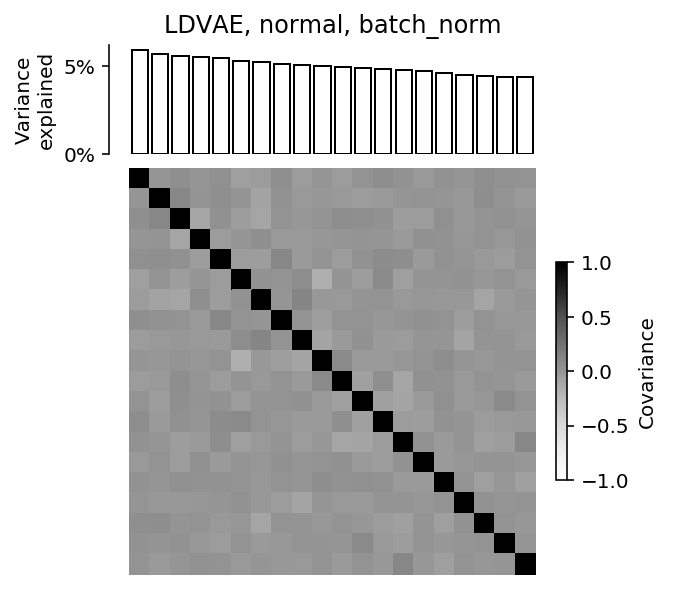

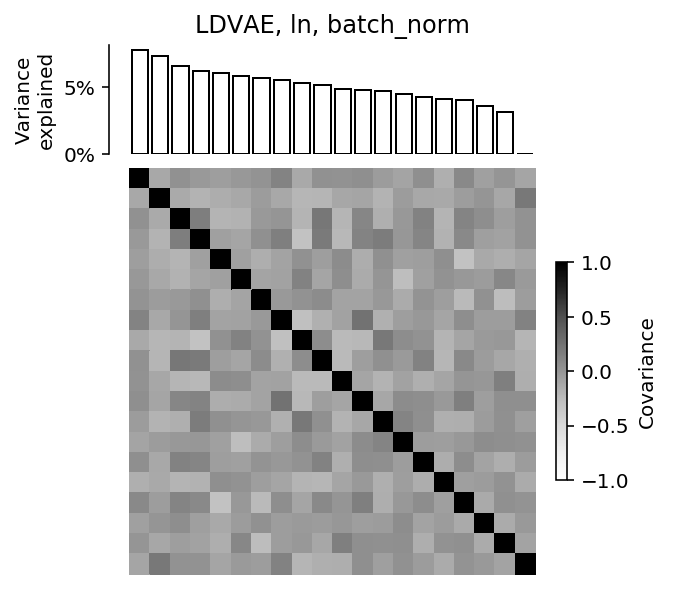

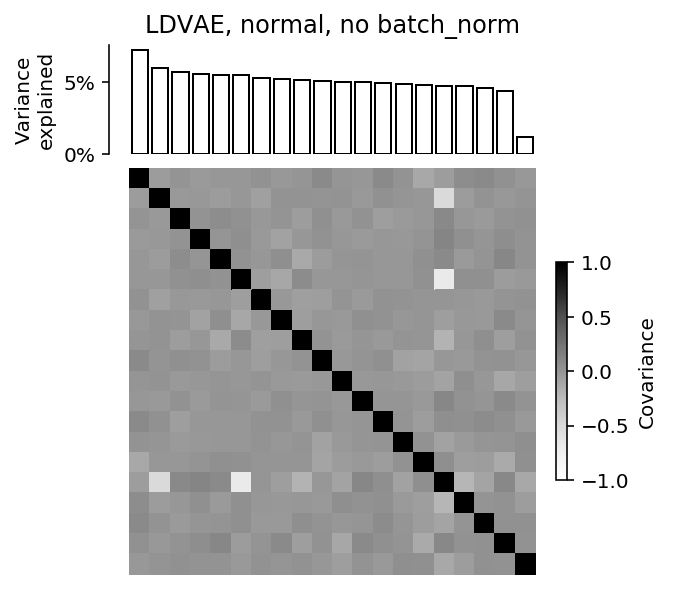

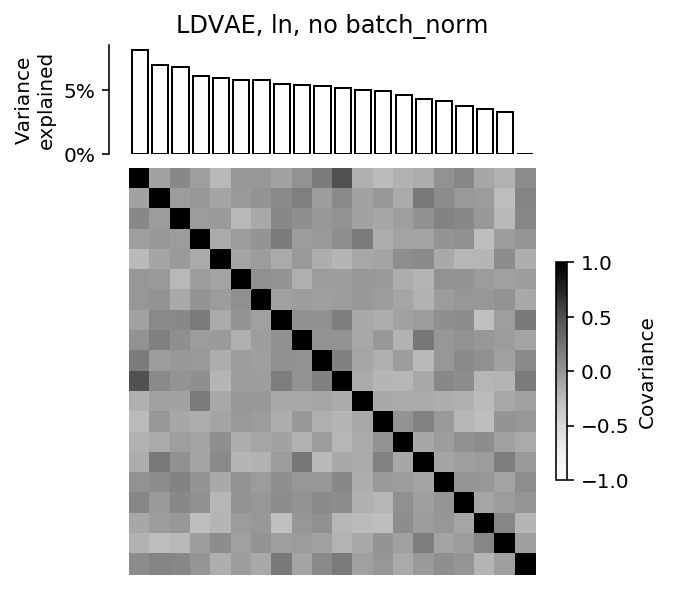

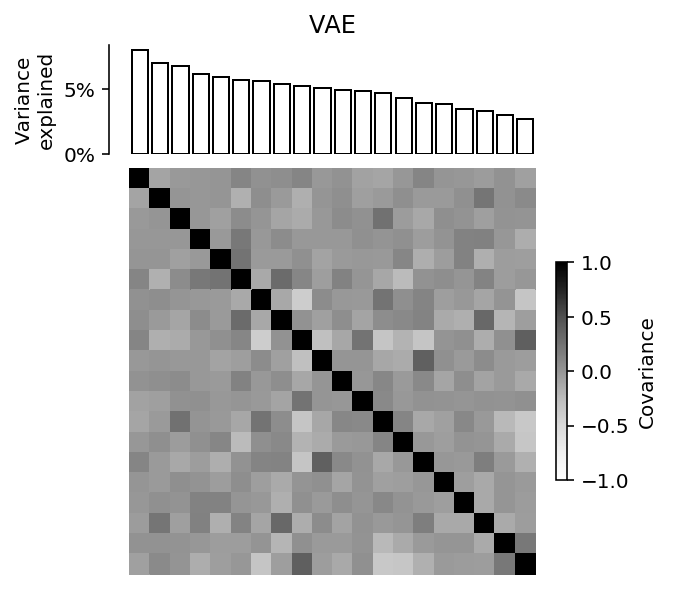

In [124]:
title_map = {
    'vae_Z.csv': 'VAE',
    'ldvae_1_Z.csv': 'LDVAE, normal, batch_norm',
    'ldvae_2_Z.csv': 'LDVAE, ln, batch_norm',
    'ldvae_3_Z.csv': 'LDVAE, normal, no batch_norm',
    'ldvae_4_Z.csv': 'LDVAE, ln, no batch_norm'
}

for fname in glob('pij_vae_results\*_Z.csv'):
    Z = pd.read_csv(fname, index_col=0)
    
    ZTZ, variance_explained = Z_covariance(Z)
    idx = np.argsort(variance_explained)[::-1]
    variance_explained[idx]
    
    figsize(5, 5)
    
    model = fname.split('\\')[-1]

    fig = z_cov_plot(ZTZ, variance_explained, idx, title_map[model]);
    fig.savefig(fname.replace('Z.csv', 'Z_covar.pdf'), dpi=150, bbox_inches='tight')

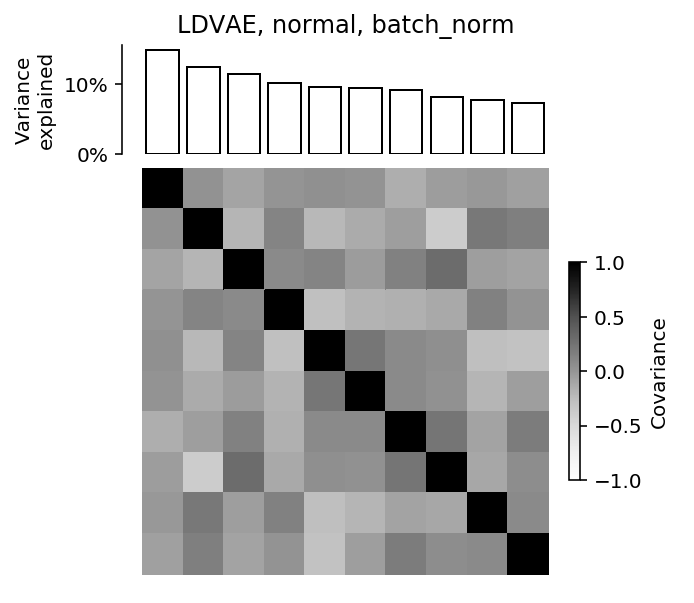

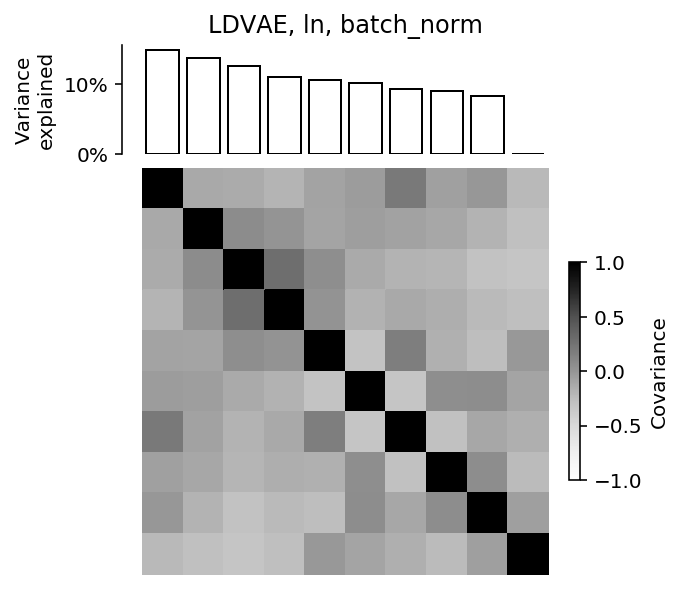

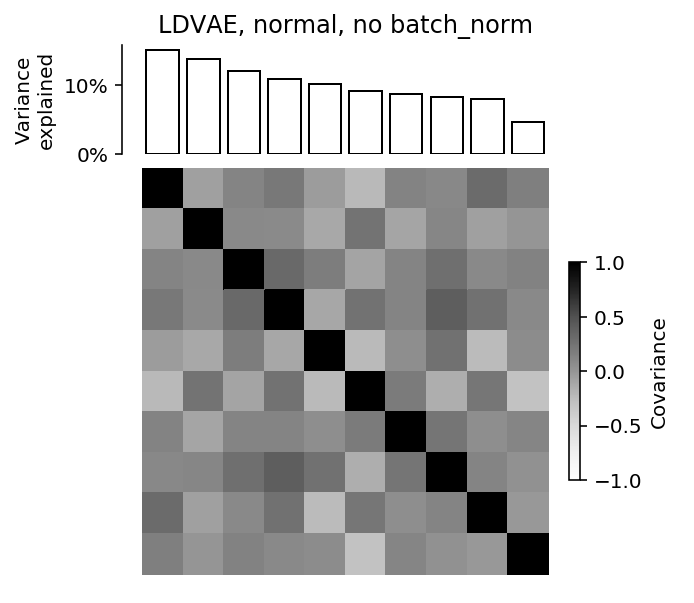

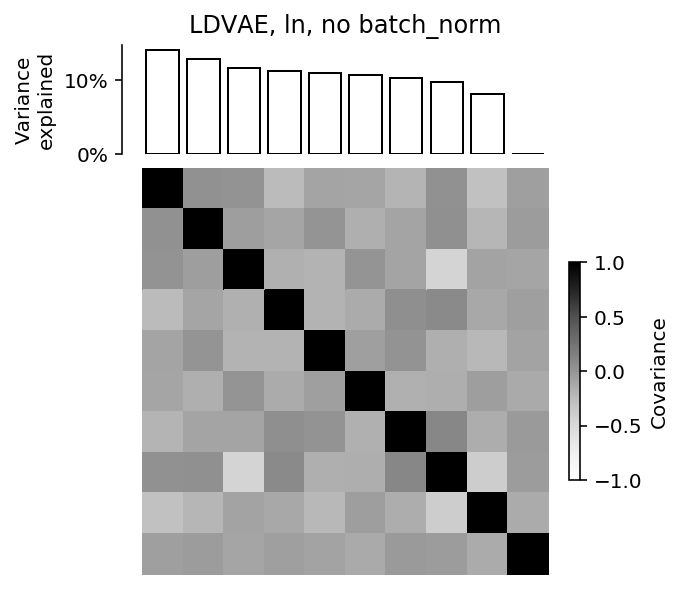

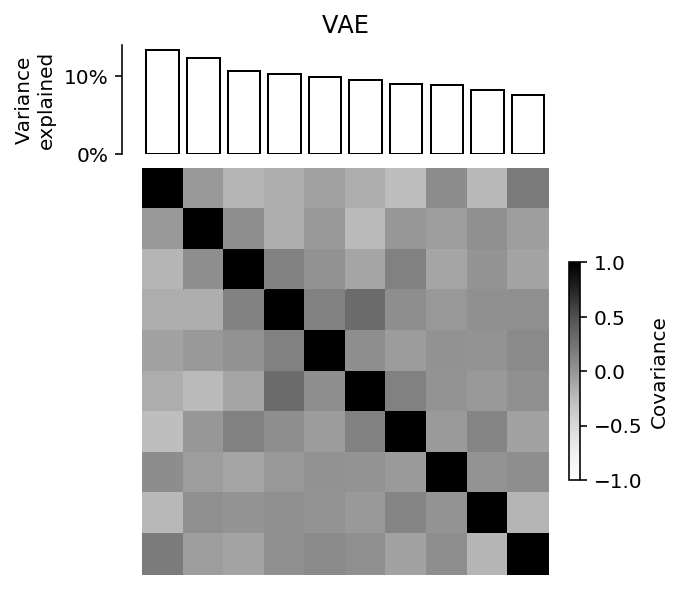

In [126]:
for fname in glob('cao_vae_results\*_Z.csv'):
    Z = pd.read_csv(fname, index_col=0)
    
    ZTZ, variance_explained = Z_covariance(Z)
    idx = np.argsort(variance_explained)[::-1]
    variance_explained[idx]
    
    figsize(5, 5)
    model = fname.split('\\')[-1]

    fig = z_cov_plot(ZTZ, variance_explained, idx, title_map[model]);
    fig.savefig(fname.replace('Z.csv', 'Z_covar.pdf'), dpi=150, bbox_inches='tight')
    